# Code for all plots on paper

## Figure 2

#### Figure 2a - Forward Modeling

Total common barcodes: 1232


Total filtered gene counts (post-remove): 4282363


/tmp/ipykernel_1281477/2976508542.py:104: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, ymax)
/tmp/ipykernel_1281477/2976508542.py:105: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, ymax)


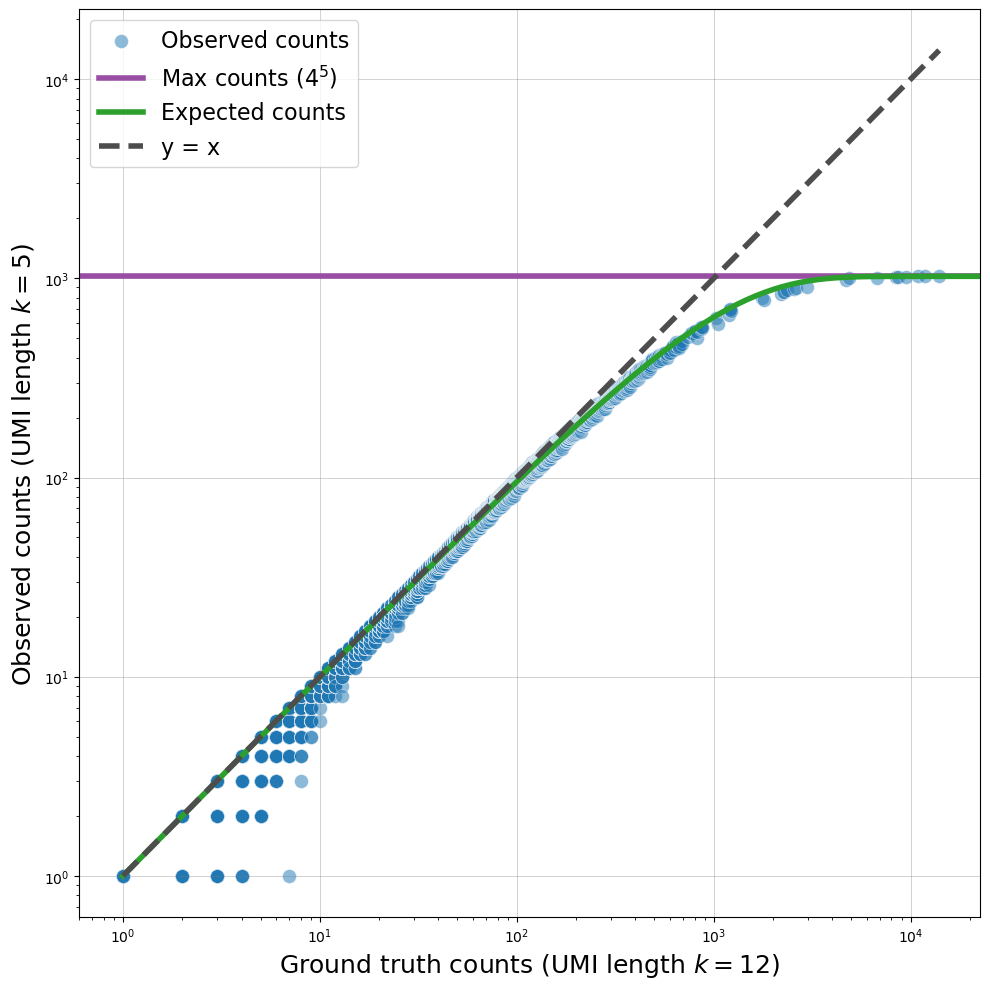

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc
import scipy.sparse as sp

# Define which genes to remove
remove = np.array([
    "MALAT1",
    # add any other gene names you want to drop here
])

dataset = "1k_PBMCs"  # Change to "1k_PBMCs" if needed

adata_dict = {}
adata_path = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices"

# --- Load only what you actually use (i=12, j=5) ---
i = 12
j = 5
adata_dict[i] = sc.read_h5ad(f"{adata_path}/adata_{i}.h5ad")
adata_dict[j] = sc.read_h5ad(f"{adata_path}/adata_{j}.h5ad")

# Model function
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

n_values = np.logspace(0, 4.5, 200)

# Align barcodes
common_barcodes = sorted(
    set(adata_dict[i].obs_names).intersection(set(adata_dict[j].obs_names))
)
print(f"Total common barcodes: {len(common_barcodes)}")

indices_i = adata_dict[i].obs_names.get_indexer(common_barcodes)
indices_j = adata_dict[j].obs_names.get_indexer(common_barcodes)

# Gene mask
gene_mask = ~np.isin(adata_dict[i].var_names, remove)

X_i = adata_dict[i].X[indices_i][:, gene_mask]
X_j = adata_dict[j].X[indices_j][:, gene_mask]

# ---------- FILTER (robust to sparse or dense) ----------
if sp.issparse(X_i):
    coo = X_i.tocoo(copy=False)
    rows, cols, vals = coo.row, coo.col, coo.data
    keep = vals >= 1
    filtered_counts_i = vals[keep]
    filtered_counts_j = X_j[rows[keep], cols[keep]].A1
else:
    mask = X_i >= 1
    filtered_counts_i = X_i[mask]
    filtered_counts_j = X_j[mask]

all_gene_counts_i = np.array(filtered_counts_i)
all_gene_counts_j = np.array(filtered_counts_j)

print(f"Total filtered gene counts (post-remove): {len(all_gene_counts_i)}")

# Sort
sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]

# Plot
plt.figure(figsize=(10, 10))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.5, 
    c='#1f77b4',
    edgecolors='w', 
    s=100,
    linewidth=0.5, 
    label='Observed counts'
)

y_asymptotic_value = 4**j
plt.axhline(
    y=y_asymptotic_value, 
    color='#984ea3', 
    linestyle='-', 
    linewidth=4, 
    label=f'Max counts ($4^{{{j}}}$)'
)

model_vals = f(n_values, j)
plt.plot(
    n_values, 
    model_vals, 
    color='#2ca02c',
    linewidth=4, 
    label='Expected counts'
)

max_val = max(sorted_gene_counts_i.max(), sorted_gene_counts_j.max())
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

plt.xscale('log')
plt.yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.xlim(0, ymax)
plt.ylabel(r"Observed counts (UMI length $k=5$)", fontsize=18)
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left", fontsize=16)

plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/observed_vs_ground_truth_counts_remove_MALAT1.jpeg", dpi=300)
plt.show()
plt.close()


#### Figure 2b - Inverse 

Total common barcodes: 11458
Total filtered gene counts: 39412817


/tmp/ipykernel_1281477/1566072076.py:85: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0, ymax)
/tmp/ipykernel_1281477/1566072076.py:86: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0, ymax)


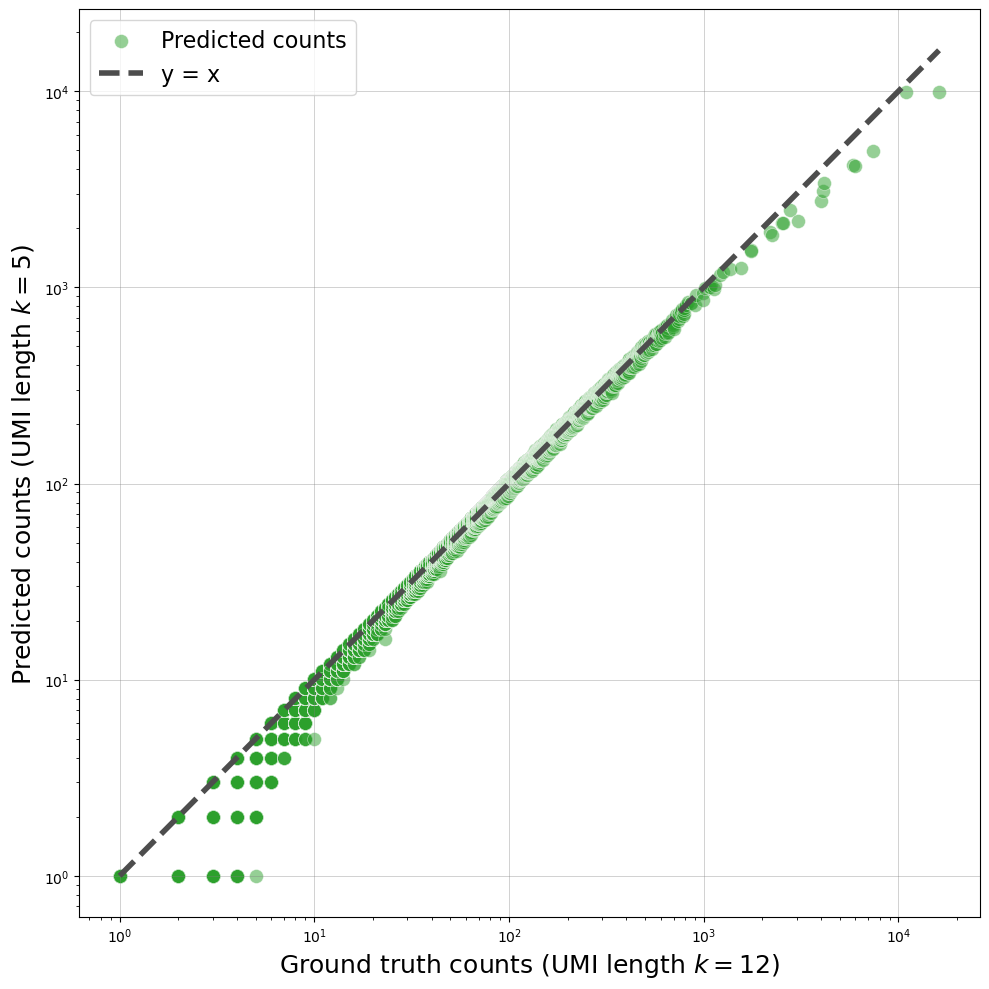

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scanpy as sc

# dataset = "1k_PBMCs" 
dataset = "10k_PBMCs" 

adata_12 = sc.read_h5ad(
    f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_12.h5ad"
)

# Only load what you use (j=5) to avoid unnecessary I/O
adata_dict = {}
j = 5
adata_dict[j] = sc.read_h5ad(
    f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/col_aware_nunif_matrices/adata_{j}.h5ad"
)

# Define which genes to remove
remove = np.array([
    "MALAT1",
    # add any other gene names you want to drop here
])

# Your model function (kept for parity, though not used in this plot block)
def f(n_vals, j):
    return 4**j * (1 - (1 - 1 / 4**j)**n_vals)

# Fixed UMI length for "true" counts
i = 12
n_values = np.logspace(0, 4.5, 200)

# Ensure both datasets are properly aligned (fast indexer; no O(n^2) list.index)
common_barcodes = sorted(set(adata_12.obs_names).intersection(set(adata_dict[j].obs_names)))
print(f"Total common barcodes: {len(common_barcodes)}")

indices_i = adata_12.obs_names.get_indexer(common_barcodes)
indices_j = adata_dict[j].obs_names.get_indexer(common_barcodes)

# Create a mask for genes to **keep** (i.e. not in 'remove')
gene_mask = ~np.isin(np.asarray(adata_12.var_names), remove)

# Pull full matrices at once, subsetting both cells and genes
X_i = adata_12.X[indices_i][:, gene_mask]
X_j = adata_dict[j].X[indices_j][:, gene_mask]

# ---- FILTER (dense path only) ----
mask = X_i >= 1
filtered_counts_i = X_i[mask]
filtered_counts_j = X_j[mask]

# Convert to numpy arrays (kept for parity)
all_gene_counts_i = np.array(filtered_counts_i)
all_gene_counts_j = np.array(filtered_counts_j)

print(f"Total filtered gene counts: {len(all_gene_counts_i)}")

# Sort by the "ground truth" values exactly as you did
sorted_indices = np.argsort(all_gene_counts_i)
sorted_gene_counts_i = all_gene_counts_i[sorted_indices]
sorted_gene_counts_j = all_gene_counts_j[sorted_indices]

# Create plot (styling preserved)
plt.figure(figsize=(10, 10))
plt.scatter(
    sorted_gene_counts_i, 
    sorted_gene_counts_j, 
    alpha=0.5, 
    c='#2ca02c',     # Standard Green for Points (kept)
    edgecolors='w', 
    s=100,           
    linewidth=0.5, 
    label='Predicted counts'
)

# Reference y = x line
max_val = max(sorted_gene_counts_i.max() if len(sorted_gene_counts_i) else 1,
              sorted_gene_counts_j.max() if len(sorted_gene_counts_j) else 1)
plt.plot([1, max_val], [1, max_val], linestyle='--', color='#4D4D4D', linewidth=4, label='y = x')

plt.xscale('log')
plt.yscale('log')
ymin, ymax = plt.ylim()
plt.ylim(0, ymax)
plt.xlim(0, ymax)
plt.ylabel(r"Predicted counts (UMI length $k=5$)", fontsize=18)
plt.xlabel(r"Ground truth counts (UMI length $k=12$)", fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(loc="upper left", fontsize=16)

plt.tight_layout()
plt.savefig(
    f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/predicted_vs_ground_truth_counts_remove_MALAT1.jpeg", 
    dpi=300
)
plt.show()
plt.close()



#### Figure 2c - TVD 

In [ ]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt

def tvd(p, q):
    """
    Calculate the Total Variation Distance (TVD) between two probability distributions p and q.
    Assumes that p and q are numpy arrays with the same length.
    """
    p = np.array(p, dtype=np.float64)
    q = np.array(q, dtype=np.float64)
    
    if np.isnan(p).any() or np.isinf(p).any():
        raise ValueError("Input array p contains NaN or infinite values.")
    if np.isnan(q).any() or np.isinf(q).any():
        raise ValueError("Input array q contains NaN or infinite values.")
    
    sum_p = np.sum(p)
    sum_q = np.sum(q)
    if sum_p == 0 or sum_q == 0:
        raise ValueError("Sum of the input arrays should not be zero.")
    
    p = p / sum_p
    q = q / sum_q
    return 0.5 * np.sum(np.abs(p - q))

dataset = "1k_PBMCs"  # Change to "10k_PBMCs" if needed

remove = np.array(['MALAT1'])  # <-- replace with your list

# Loading the regular adata matrices
common_path = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices"
regular_adata_dict = {}
for i in range(1, 13):
    path = f"{common_path}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    regular_adata_dict[i] = adata

# Loading the inverted non-unif matrices
common_path2 = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/inv_nonunif_matrices"
non_unif_adata_dict = {}
for i in range(1, 12):
    path = f"{common_path2}/adata_{i}.h5ad"
    adata = sc.read_h5ad(path)
    adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
    non_unif_adata_dict[i] = adata
adata = sc.read_h5ad(f"{common_path}/adata_12.h5ad")
adata = adata[:, ~np.in1d(adata.var_names, remove)].copy()
non_unif_adata_dict[12] = adata

# This is the ground truth adata matrix
gt_adata12 = regular_adata_dict[12]

# Initialize lists to store the mean and quantile-based confidence intervals
mean_errors = []
ci_low_errors = []
ci_high_errors = []

mean_errors2 = []
ci_low_errors2 = []
ci_high_errors2 = []

# Compute TVD for regular and inverted matrices against the ground truth
for i in range(1, 13):
    # Errors for regular matrices
    errors = []
    for barcode in gt_adata12.obs_names:
        index1 = np.where(regular_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        gene_counts1 = regular_adata_dict[i].X[index1]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        if not isinstance(gene_counts1, np.ndarray):
            gene_counts1 = gene_counts1.toarray().flatten()
        else:
            gene_counts1 = gene_counts1.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        mask = gene_counts_gt >= 1
        gene_counts1 = gene_counts1[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        sorted_indices = np.argsort(gene_counts1)
        sorted_gene_counts1 = gene_counts1[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        error = tvd(sorted_gene_counts1, sorted_gene_counts_gt)
        errors.append(error)
    
    mean_errors.append(np.mean(errors))
    q_low, q_high = np.percentile(errors, [2.5, 97.5])
    ci_low_errors.append(np.mean(errors) - q_low)
    ci_high_errors.append(q_high - np.mean(errors))
    
    # Errors for non-uniform matrices
    errors2 = []
    for barcode in gt_adata12.obs_names:
        index2 = np.where(non_unif_adata_dict[i].obs_names == barcode)[0][0]
        index_gt = np.where(gt_adata12.obs_names == barcode)[0][0]
        
        gene_counts2 = non_unif_adata_dict[i].X[index2]
        gene_counts_gt = gt_adata12.X[index_gt]
        
        if not isinstance(gene_counts2, np.ndarray):
            gene_counts2 = gene_counts2.toarray().flatten()
        else:
            gene_counts2 = gene_counts2.flatten()
        
        if not isinstance(gene_counts_gt, np.ndarray):
            gene_counts_gt = gene_counts_gt.toarray().flatten()
        else:
            gene_counts_gt = gene_counts_gt.flatten()
        
        mask = gene_counts_gt >= 1
        gene_counts2 = gene_counts2[mask]
        gene_counts_gt = gene_counts_gt[mask]
        
        sorted_indices = np.argsort(gene_counts2)
        sorted_gene_counts2 = gene_counts2[sorted_indices]
        sorted_gene_counts_gt = gene_counts_gt[sorted_indices]
        
        error2 = tvd(sorted_gene_counts2, sorted_gene_counts_gt)
        errors2.append(error2)  
    
    mean_errors2.append(np.mean(errors2))
    q_low2, q_high2 = np.percentile(errors2, [2.5, 97.5])
    ci_low_errors2.append(np.mean(errors2) - q_low2)
    ci_high_errors2.append(q_high2 - np.mean(errors2))

print(mean_errors)
print(mean_errors2)

# Plotting the errors with quantile-based CI
num_experiments = len(mean_errors)

plt.figure(figsize=(10, 10))

# Plot errors for the Regular Matrices (Naive Estimator)
plt.errorbar(
    range(1, num_experiments), 
    mean_errors[:-1], 
    yerr=[ci_low_errors[:-1], ci_high_errors[:-1]], 
    fmt='o-', 
    color='#1f77b4',
    ecolor='#1f77b4',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Naive estimator'
)

# Plot errors for the Inverted Non-Uniform Matrices (Collision-aware Estimator)
plt.errorbar(
    range(1, num_experiments), 
    mean_errors2[:-1], 
    yerr=[ci_low_errors2[:-1], ci_high_errors2[:-1]], 
    fmt='o-', 
    color='#2ca02c',
    ecolor='#2ca02c',
    linewidth=3,
    elinewidth=3, 
    capsize=4, 
    markersize=10,
    label='Non-uniform estimator'
)

plt.xlabel('UMI length', fontsize=18)
plt.ylabel('Error (Total variation distance)', fontsize=20)
plt.ylim(bottom=0)
# plt.yscale('log')
plt.legend(fontsize=16)  
plt.grid(True, linestyle='--', linewidth=0.5, color='gray', alpha=0.7)
plt.tight_layout()

plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/1k_tvd_plot.pdf")
plt.show()


### Figures 2d-e

UMI-5: SSE naive=0.050883, SSE pred=0.002636
UMI-5: MSE naive=0.000471, MSE pred=0.000024


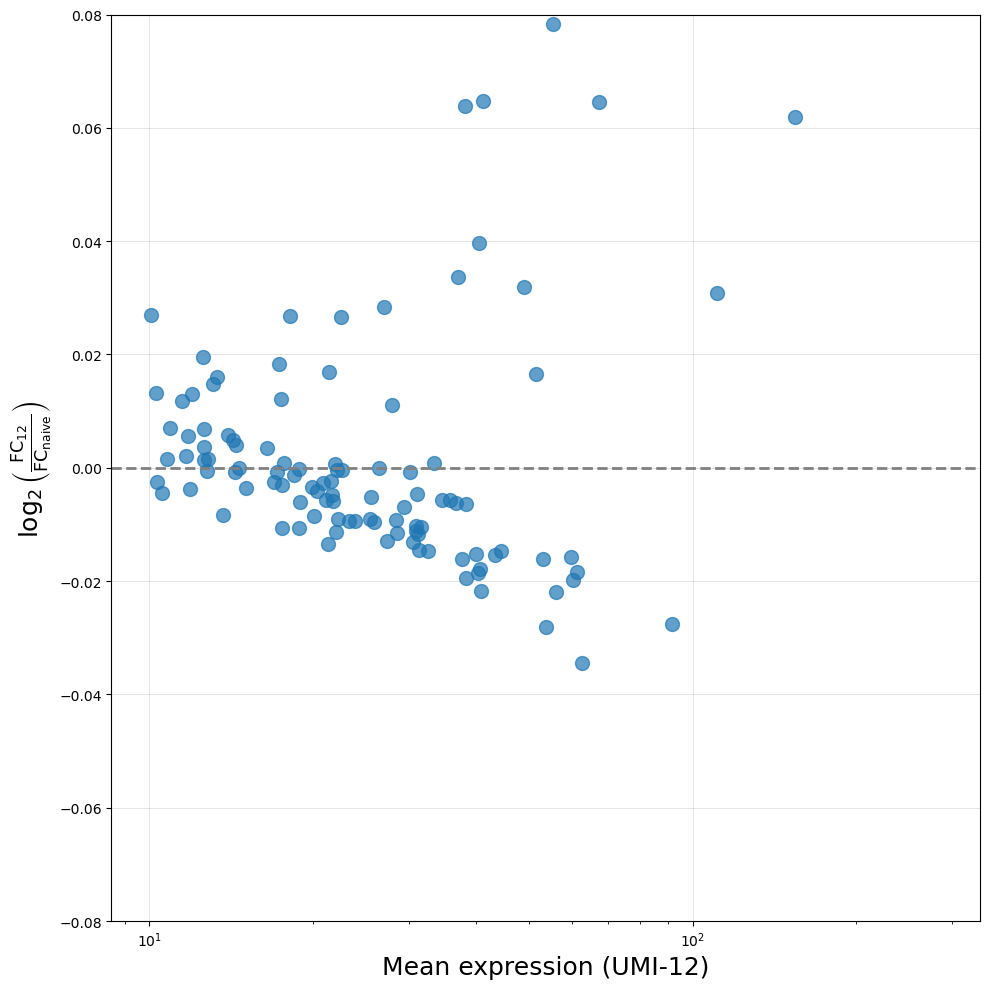

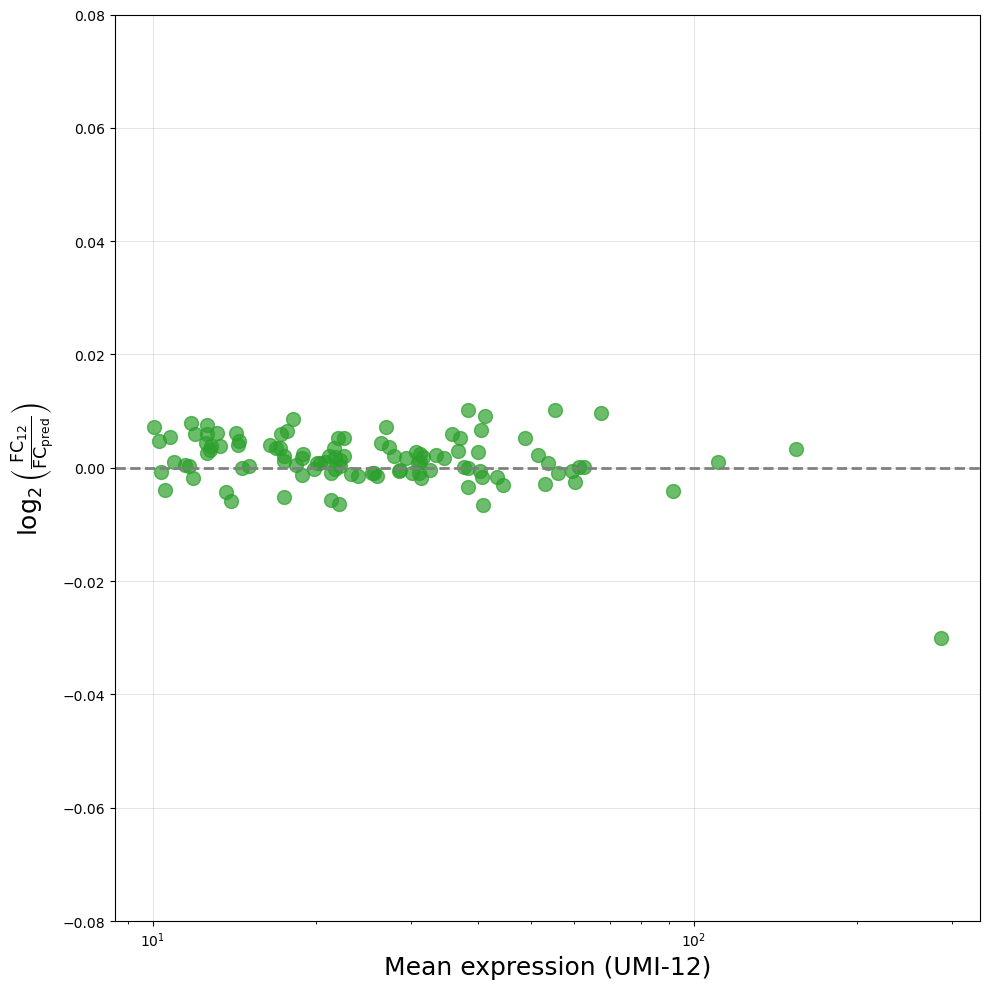

In [3]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from pathlib import Path


j = 5                 
# genes are CD14_mono, CD4.Naive, B_naive     
GENE_LABEL = "CD4.Naive"

METHOD = 'wilcoxon'
FC_HI = np.log2(1.25)        # ≈ 0.32
FC_LO = -np.log2(1.25)       # ≈ -0.32
PVAL_THRESH = 0.05
AVG_COUNT_MIN = 10
dataset = "1k_PBMCs"  # Change to "10k_PBMCs" if needed

GT_PATH = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_12.h5ad"
LAB_PATH = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad"
NAIVE_FMT = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_{j}.h5ad"
PRED_FMT  = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/col_aware_nunif_matrices/adata_{j}.h5ad"


adata_gt = sc.read_h5ad(GT_PATH)
labels = sc.read_h5ad(LAB_PATH)
reference_labels = labels.obs['majority_voting'].copy()
binary_labels = reference_labels.apply(lambda x: GENE_LABEL if x == GENE_LABEL else 'Other cells')

# normalized GT copy for DE
adata_12_norm = adata_gt.copy()
sc.pp.normalize_total(adata_12_norm, target_sum=1e4)
sc.pp.log1p(adata_12_norm)
adata_12_norm.obs['label'] = binary_labels.loc[adata_12_norm.obs_names]

# GT DE (UMI=12)
sc.tl.rank_genes_groups(
    adata_12_norm,
    groupby='label',
    method=METHOD,
    key_added=METHOD,
    use_raw=False
)
de_12 = sc.get.rank_genes_groups_df(adata_12_norm, group=GENE_LABEL, key=METHOD)

# avg counts from raw GT
X12 = adata_gt.X
avg12 = (np.asarray(X12.mean(axis=0)).ravel() if sp.issparse(X12) else X12.mean(axis=0))
df_avg12 = pd.DataFrame({"gene": adata_gt.var_names, "avg_count": avg12})

# attach avg to GT DE and filter genes (based only on GT)
de_12_avg = de_12.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
pcol = 'pvals_adj' if 'pvals_adj' in de_12_avg.columns else 'pvals'
keep_genes = de_12_avg.loc[
    ((de_12_avg['logfoldchanges'] >= FC_HI) | (de_12_avg['logfoldchanges'] <= FC_LO))
    & (de_12_avg[pcol] < PVAL_THRESH)
    & (de_12_avg['avg_count'] >= AVG_COUNT_MIN),
    'names'
].astype(str).values


naive_path = NAIVE_FMT.format(j=j)
pred_path  = PRED_FMT.format(j=j)
assert Path(naive_path).exists(), f"Missing file: {naive_path}"
assert Path(pred_path).exists(),  f"Missing file: {pred_path}"

adata_naive = sc.read_h5ad(naive_path)
adata_pred  = sc.read_h5ad(pred_path)

# alignment checks
assert adata_gt.obs_names.equals(adata_naive.obs_names), f"Cell barcodes differ at UMI-{j} (naive)."
assert adata_gt.var_names.equals(adata_naive.var_names), f"Genes differ at UMI-{j} (naive)."
assert adata_gt.obs_names.equals(adata_pred.obs_names),  f"Cell barcodes differ at UMI-{j} (pred)."
assert adata_gt.var_names.equals(adata_pred.var_names),  f"Genes differ at UMI-{j} (pred)."

# normalize/log1p & labels
for ad in (adata_naive, adata_pred):
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)
    ad.obs['label'] = binary_labels.loc[ad.obs_names]

# DE at j
sc.tl.rank_genes_groups(adata_naive, groupby='label', method=METHOD, key_added=METHOD, use_raw=False)
sc.tl.rank_genes_groups(adata_pred,  groupby='label', method=METHOD, key_added=METHOD, use_raw=False)

de_naive = sc.get.rank_genes_groups_df(adata_naive, group=GENE_LABEL, key=METHOD)
de_pred  = sc.get.rank_genes_groups_df(adata_pred,  group=GENE_LABEL, key=METHOD)

# attach avg and restrict to keep_genes
de_naive_avg = de_naive.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
de_pred_avg  = de_pred .merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")

lost_naive = set(de_12_avg['names']) - set(de_naive_avg['names'])
lost_pred  = set(de_12_avg['names']) - set(de_pred_avg['names'])
if lost_naive:
    print(f"[warn] {len(lost_naive)} genes in UMI-12 are missing from naive.")
if lost_pred:
    print(f"[warn] {len(lost_pred)} genes in UMI-12 are missing from pred.")


de_12_k    = de_12_avg   [de_12_avg['names'].isin(keep_genes)]
de_naive_k = de_naive_avg[de_naive_avg['names'].isin(keep_genes)]
de_pred_k  = de_pred_avg [de_pred_avg['names'].isin(keep_genes)]

# merge three on names and sort by abundance
df = (
    de_12_k[['names', 'logfoldchanges', 'avg_count']]
      .rename(columns={'logfoldchanges': 'lfc_12'})
      .merge(
          de_naive_k[['names', 'logfoldchanges']].rename(columns={'logfoldchanges': 'lfc_naive'}),
          on='names',
          how='left',
          validate='one_to_one'
      )
      .merge(
          de_pred_k[['names', 'logfoldchanges']].rename(columns={'logfoldchanges': 'lfc_pred'}),
          on='names',
          how='left',
          validate='one_to_one'
      )
      .sort_values('avg_count')
      .reset_index(drop=True)
)


# per-gene squared errors, SSE, MSE
se_naive = (df['lfc_naive'].to_numpy() - df['lfc_12'].to_numpy())**2
se_pred  = (df['lfc_pred' ].to_numpy() - df['lfc_12'].to_numpy())**2

sse_naive = float(se_naive.sum()) if se_naive.size else np.nan
sse_pred  = float(se_pred.sum())  if se_pred.size  else np.nan
mse_naive = float(se_naive.mean()) if se_naive.size else np.nan
mse_pred  = float(se_pred.mean())  if se_pred.size  else np.nan

print(f"UMI-{j}: SSE naive={sse_naive:.6f}, SSE pred={sse_pred:.6f}")
print(f"UMI-{j}: MSE naive={mse_naive:.6f}, MSE pred={mse_pred:.6f}")


# Plots for this j
df["logrf_naive"] = df['lfc_naive'] - df['lfc_12']
df["logrf_pred"]  = df['lfc_pred']  - df['lfc_12']

# Plot: Ground truth vs Naive
plt.figure(figsize=(10, 10))
plt.scatter(df['avg_count'], df['logrf_naive'], alpha=0.7, color='#1f77b4', s=100)
plt.axhline(0, color='grey', linestyle='--', linewidth=2)
plt.xscale('log')
plt.xlabel('Mean expression (UMI-12)', fontsize=18)
plt.ylabel(r"$\log_2\left(\frac{\mathrm{FC}_{12}}{\mathrm{FC}_{\mathrm{naive}}}\right)$", fontsize=18)
plt.ylim(-0.08, 0.08)
plt.grid(True, which='major', linestyle='-', linewidth=0.5, color='gray', alpha=0.3)
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/{dataset}_{GENE_LABEL}_logfc_naive_UMI_{j}.pdf")
plt.show()

# Plot: Ground truth vs Predicted
plt.figure(figsize=(10, 10))
plt.scatter(df['avg_count'], df['logrf_pred'], alpha=0.7, color='#2ca02c', s=100)
plt.axhline(0, color='grey', linestyle='--', linewidth=2)
plt.xscale('log')
plt.xlabel('Mean expression (UMI-12)', fontsize=18)
plt.ylabel(r"$\log_2\left(\frac{\mathrm{FC}_{12}}{\mathrm{FC}_{\mathrm{pred}}}\right)$", fontsize=18)
plt.ylim(-0.08, 0.08)
plt.grid(True, which='major', linestyle='-', linewidth=0.5, color='gray', alpha=0.3)
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/{dataset}_{GENE_LABEL}_logfc_pred_UMI_{j}.pdf")
plt.show()


#### All genes with 100 or more cells: CD14_mono

CD14_mono  | n= 111 | SSE naive=0.082176  MSE naive=0.000740 | SSE pred=0.003628    MSE pred=0.000033
B_naive    | n=  98 | SSE naive=0.023614  MSE naive=0.000241 | SSE pred=0.002491    MSE pred=0.000025
CD4.Naive  | n= 108 | SSE naive=0.050883  MSE naive=0.000471 | SSE pred=0.002636    MSE pred=0.000024


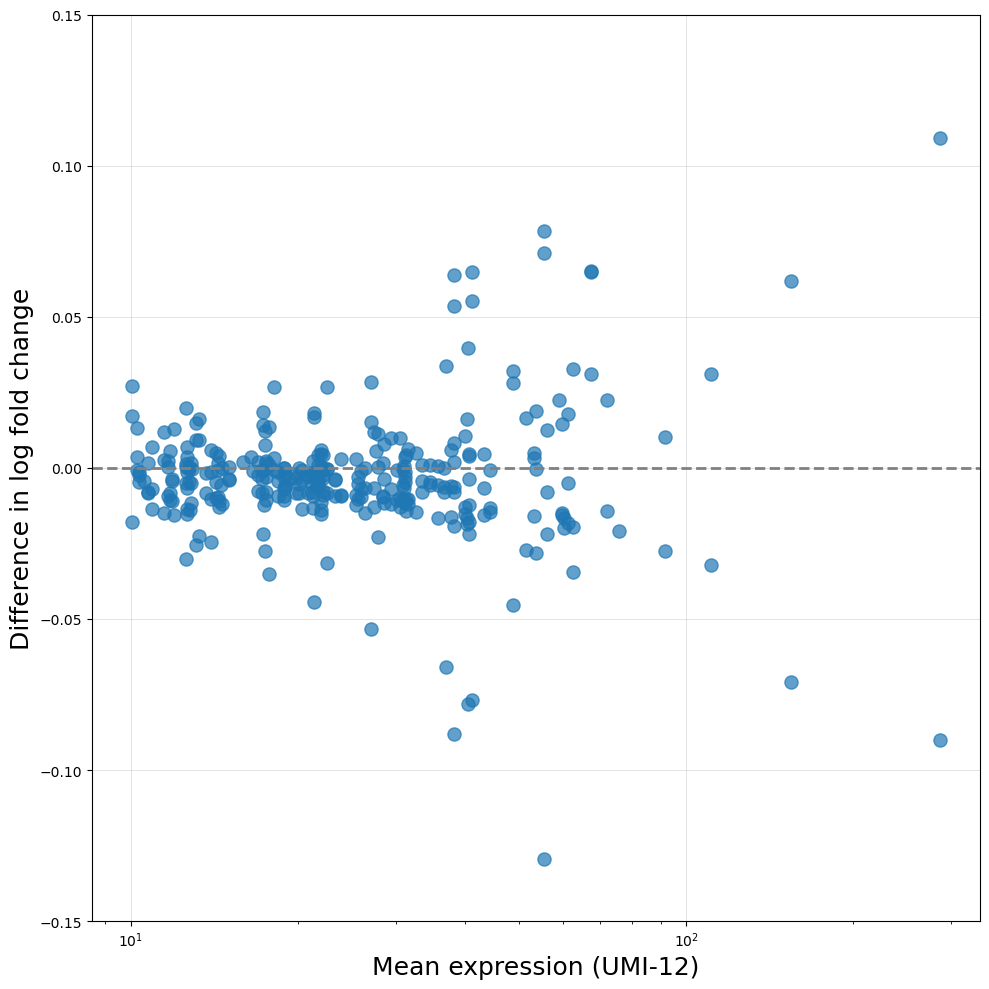

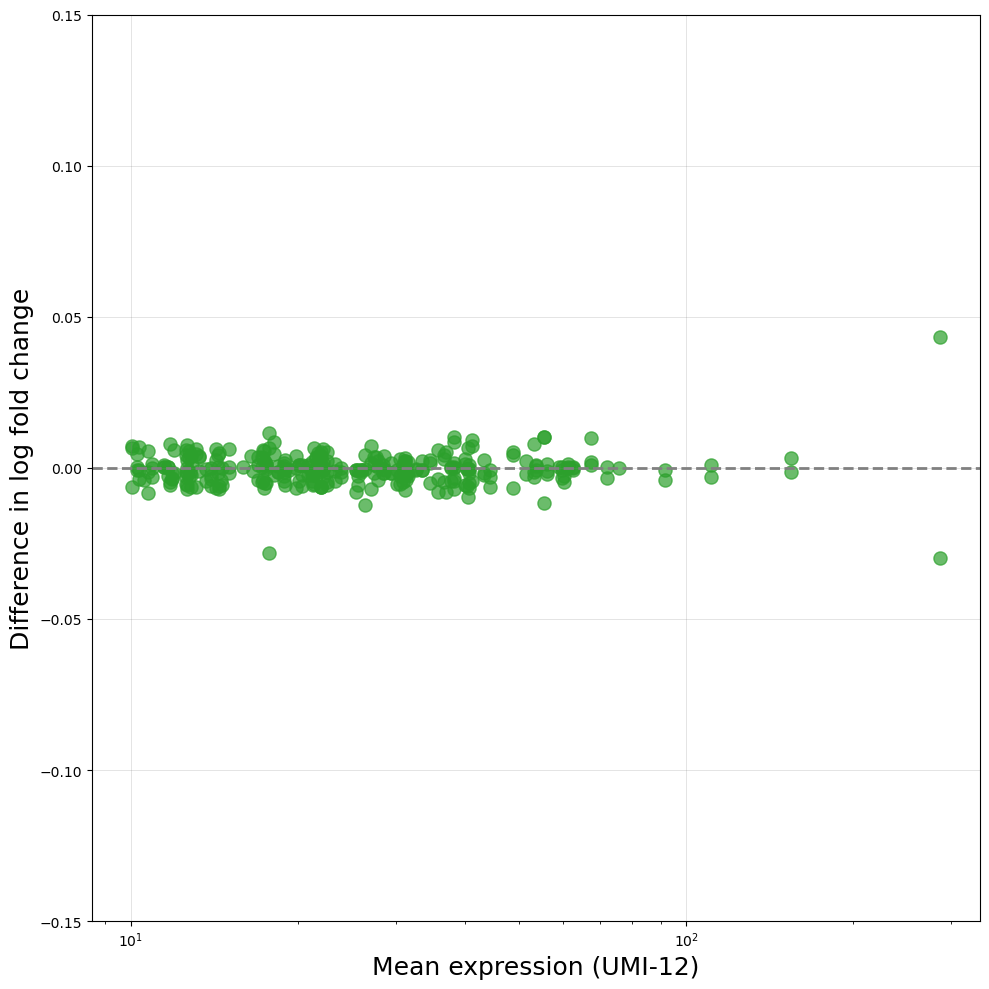

In [6]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from pathlib import Path

# Config you can tweak
j = 5
GENES = ["CD14_mono", "B_naive", "CD4.Naive"]

METHOD = "wilcoxon"
FC_HI = np.log2(1.25)     # ≈ +0.32
FC_LO = -np.log2(1.25)    # ≈ -0.32
PVAL_THRESH = 0.05
AVG_COUNT_MIN = 10
dataset = "1k_PBMCs"      # flip to "10k_PBMCs" if you want

# I/O
GT_PATH  = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_12.h5ad"
LAB_PATH = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad"
NAIVE    = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_{j}.h5ad"
PRED     = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/col_aware_nunif_matrices/adata_{j}.h5ad"

# Visual style per gene — keep these consistent across plots so it's readable at a glance
STYLE_1 = {
    "CD14_mono": {"color": "#1f77b4", "marker": "o", "label": "CD14_mono"},
    "B_naive":   {"color": "#1f77b4", "marker": "o", "label": "B_naive"},
    "CD4.Naive": {"color": "#1f77b4", "marker": "o", "label": "CD4.Naive"},
}

STYLE_2 = {
    "CD14_mono": {"color": "#2ca02c", "marker": "o", "label": "CD14_mono"},
    "B_naive":   {"color": "#2ca02c", "marker": "o", "label": "B_naive"},
    "CD4.Naive": {"color": "#2ca02c", "marker": "o", "label": "CD4.Naive"},
}

# Sanity checks up front
for p in [GT_PATH, LAB_PATH, NAIVE, PRED]:
    assert Path(p).exists(), f"Missing file: {p}"

# Load once, reuse
adata_gt   = sc.read_h5ad(GT_PATH)
labels     = sc.read_h5ad(LAB_PATH)
adata_naive = sc.read_h5ad(NAIVE)
adata_pred  = sc.read_h5ad(PRED)

# The big alignment checks (let's fail fast if something is off)
assert adata_gt.obs_names.equals(adata_naive.obs_names), f"Cell barcodes differ at UMI-{j} (naive)."
assert adata_gt.var_names.equals(adata_naive.var_names), f"Genes differ at UMI-{j} (naive)."
assert adata_gt.obs_names.equals(adata_pred.obs_names),  f"Cell barcodes differ at UMI-{j} (pred)."
assert adata_gt.var_names.equals(adata_pred.var_names),  f"Genes differ at UMI-{j} (pred)."

# We'll normalize the UMI-j matrices once; labels change per gene but normalization doesn't
for ad in (adata_naive, adata_pred):
    sc.pp.normalize_total(ad, target_sum=1e4)
    sc.pp.log1p(ad)

# Precompute average counts from the raw GT matrix (no log1p here)
X12 = adata_gt.X
avg12 = (np.asarray(X12.mean(axis=0)).ravel() if sp.issparse(X12) else X12.mean(axis=0))
df_avg12 = pd.DataFrame({"gene": adata_gt.var_names, "avg_count": avg12})

# We’ll stash all points across genes into these two lists, then plot together
rows_naive = []  # each entry: dict(avg_count=..., logrf_naive=..., gene=...)
rows_pred  = []  # each entry: dict(avg_count=..., logrf_pred=...,  gene=...)

# (Optional) keep a quick scoreboard for SSE/MSE per gene — handy to print out
metrics = {}

# Core loop per gene
for gene_label in GENES:
    # Binary label: target vs everything else for DE
    reference_labels = labels.obs["majority_voting"].copy()
    binary_labels = reference_labels.apply(lambda x: gene_label if x == gene_label else "Other cells")

    # --- GT DE (on a normalized/log1p copy so we don't mutate the raw)
    adata_12_norm = adata_gt.copy()
    sc.pp.normalize_total(adata_12_norm, target_sum=1e4)
    sc.pp.log1p(adata_12_norm)
    adata_12_norm.obs["label"] = binary_labels.loc[adata_12_norm.obs_names]

    sc.tl.rank_genes_groups(
        adata_12_norm,
        groupby="label",
        method=METHOD,
        key_added=METHOD,
        use_raw=False
    )
    de_12 = sc.get.rank_genes_groups_df(adata_12_norm, group=gene_label, key=METHOD)

    # Attach avg counts and pick the "meaningful" genes based on GT only
    de_12_avg = de_12.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
    pcol = "pvals_adj" if "pvals_adj" in de_12_avg.columns else "pvals"
    keep_genes = de_12_avg.loc[
        ((de_12_avg["logfoldchanges"] >= FC_HI) | (de_12_avg["logfoldchanges"] <= FC_LO))
        & (de_12_avg[pcol] < PVAL_THRESH)
        & (de_12_avg["avg_count"] >= AVG_COUNT_MIN),
        "names"
    ].astype(str).values

    # --- Naive DE and Pred DE at UMI-j
    # Important bit: set labels per gene before DE
    adata_naive.obs["label"] = binary_labels.loc[adata_naive.obs_names]
    adata_pred.obs["label"]  = binary_labels.loc[adata_pred.obs_names]

    sc.tl.rank_genes_groups(adata_naive, groupby="label", method=METHOD, key_added=METHOD, use_raw=False)
    sc.tl.rank_genes_groups(adata_pred,  groupby="label", method=METHOD, key_added=METHOD, use_raw=False)

    de_naive = sc.get.rank_genes_groups_df(adata_naive, group=gene_label, key=METHOD)
    de_pred  = sc.get.rank_genes_groups_df(adata_pred,  group=gene_label, key=METHOD)

    # Attach avg and restrict to the GT-selected keep set
    de_naive_avg = de_naive.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
    de_pred_avg  = de_pred .merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")

    # Filter the three frames to the same gene list to keep pairing clean
    de_12_k    = de_12_avg   [de_12_avg["names"].isin(keep_genes)]
    de_naive_k = de_naive_avg[de_naive_avg["names"].isin(keep_genes)]
    de_pred_k  = de_pred_avg [de_pred_avg["names"].isin(keep_genes)]

    # Merge everything into one tidy df for this cell type
    df = (
        de_12_k[["names", "logfoldchanges", "avg_count"]]
        .rename(columns={"logfoldchanges": "lfc_12"})
        .merge(
            de_naive_k[["names", "logfoldchanges"]].rename(columns={"logfoldchanges": "lfc_naive"}),
            on="names", how="left", validate="one_to_one"
        )
        .merge(
            de_pred_k[["names", "logfoldchanges"]].rename(columns={"logfoldchanges": "lfc_pred"}),
            on="names", how="left", validate="one_to_one"
        )
        .sort_values("avg_count")
        .reset_index(drop=True)
    )

    # Compute residuals wrt GT (these are what you're plotting)
    df["logrf_naive"] = df["lfc_naive"] - df["lfc_12"]
    df["logrf_pred"]  = df["lfc_pred"]  - df["lfc_12"]

    # SSE/MSE scoreboard — nice to see printed per gene
    se_naive = (df["lfc_naive"].to_numpy() - df["lfc_12"].to_numpy())**2
    se_pred  = (df["lfc_pred" ].to_numpy() - df["lfc_12"].to_numpy())**2

    sse_naive = float(se_naive.sum())  if se_naive.size else np.nan
    sse_pred  = float(se_pred.sum())   if se_pred.size  else np.nan
    mse_naive = float(se_naive.mean()) if se_naive.size else np.nan
    mse_pred  = float(se_pred.mean())  if se_pred.size  else np.nan

    metrics[gene_label] = {
        "SSE_naive": sse_naive, "MSE_naive": mse_naive,
        "SSE_pred":  sse_pred,  "MSE_pred":  mse_pred,
        "n_genes":   int(df.shape[0])
    }

    # Stash rows for the combined plots
    for avg, v in zip(df["avg_count"], df["logrf_naive"]):
        rows_naive.append({"avg_count": float(avg), "logrf_naive": float(v), "gene": gene_label})
    for avg, v in zip(df["avg_count"], df["logrf_pred"]):
        rows_pred.append({"avg_count": float(avg), "logrf_pred": float(v), "gene": gene_label})

# Print quick metrics
for g, m in metrics.items():
    print(
        f"{g:<10s} | n={m['n_genes']:4d} | "
        f"SSE naive={m['SSE_naive']:.6f}  MSE naive={m['MSE_naive']:.6f} | "
        f"SSE pred={m['SSE_pred']:.6f}    MSE pred={m['MSE_pred']:.6f}"
    )

# Build combined dataframes for plotting
plot_naive = pd.DataFrame(rows_naive)
plot_pred  = pd.DataFrame(rows_pred)

# Plot 1: GT vs Naive (all three genes)
plt.figure(figsize=(10, 10))
for gene_label in GENES:
    sub = plot_naive[plot_naive["gene"] == gene_label]
    if sub.empty:
        continue
    style = STYLE_1[gene_label]
    plt.scatter(
        sub["avg_count"], sub["logrf_naive"],
        alpha=0.7, s=90, color=style["color"], marker=style["marker"],
        label=style["label"]
    )

plt.axhline(0, color="grey", linestyle="--", linewidth=2)
plt.xscale("log")
plt.xlabel("Mean expression (UMI-12)", fontsize=18)
plt.ylabel("Difference in log fold change", fontsize=18)
plt.ylim(-0.15, 0.15)  # same view window you used before
plt.grid(True, which="major", linestyle="-", linewidth=0.5, color="gray", alpha=0.3)
# plt.legend(title="Cell type", fontsize=12)
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/{dataset}_ALL_logfc_naive_UMI_{j}.pdf")
plt.show()

# Plot 2: GT vs Pred (all three genes)
plt.figure(figsize=(10, 10))
for gene_label in GENES:
    sub = plot_pred[plot_pred["gene"] == gene_label]
    if sub.empty:
        continue
    style = STYLE_2[gene_label]
    plt.scatter(
        sub["avg_count"], sub["logrf_pred"],
        alpha=0.7, s=90, color=style["color"], marker=style["marker"],
        label=style["label"]
    )

plt.axhline(0, color="grey", linestyle="--", linewidth=2)
plt.xscale("log")
plt.xlabel("Mean expression (UMI-12)", fontsize=18)
plt.ylabel("Difference in log fold change", fontsize=18)
plt.ylim(-0.15, 0.15)
plt.grid(True, which="major", linestyle="-", linewidth=0.5, color="gray", alpha=0.3)
# plt.legend(title="Cell type", fontsize=12)
plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/{dataset}_ALL_logfc_pred_UMI_{j}.pdf")
plt.show()


### Figure f 

In [ ]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.sparse as sp
import matplotlib.pyplot as plt
from pathlib import Path

# -------------------------
# Config
# -------------------------
UMI_MIN, UMI_MAX = 1, 13     # will skip any missing j via try/except
GENE_LABEL = 'CD14_mono'
METHOD = 'wilcoxon'
FC_HI = np.log2(1.25)        # ≈ 0.32
FC_LO = -np.log2(1.25)       # ≈ -0.32
PVAL_THRESH = 0.05
AVG_COUNT_MIN = 10

GT_PATH = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_12.h5ad"
LAB_PATH = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad"
NAIVE_FMT = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/adata_matrices/adata_{j}.h5ad"
PRED_FMT  = "/data/dagyeman/cellranger/bam_file_analysis/1k_PBMCs/ub_objects/inv_nonunif_matrices/adata_{j}.h5ad"

OUT_PDF  = "/data/dagyeman/cellranger/bam_file_analysis/paper_figures/mse_with_empirical_95ci.pdf"
OUT_CSV  = "/data/dagyeman/cellranger/bam_file_analysis/paper_figures/mse_with_empirical_95ci.csv"

# -------------------------
# Ground truth + labels (once)
# -------------------------
adata_gt = sc.read_h5ad(GT_PATH)
labels = sc.read_h5ad(LAB_PATH)
reference_labels = labels.obs['majority_voting'].copy()
binary_labels = reference_labels.apply(lambda x: GENE_LABEL if x == GENE_LABEL else 'Other cells')

# normalized GT copy for DE
adata_12_norm = adata_gt.copy()
sc.pp.normalize_total(adata_12_norm, target_sum=1e4)
sc.pp.log1p(adata_12_norm)
adata_12_norm.obs['label'] = binary_labels.loc[adata_12_norm.obs_names]

# GT DE
sc.tl.rank_genes_groups(
    adata_12_norm,
    groupby='label',
    method=METHOD,
    key_added=METHOD,
    use_raw=False
)
de_12 = sc.get.rank_genes_groups_df(adata_12_norm, group=GENE_LABEL, key=METHOD)

# avg counts from *raw* GT
X12 = adata_gt.X
avg12 = (np.asarray(X12.mean(axis=0)).ravel() if sp.issparse(X12) else X12.mean(axis=0))
df_avg12 = pd.DataFrame({"gene": adata_gt.var_names, "avg_count": avg12})

# attach avg to GT DE
de_12_avg = de_12.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")

# filter genes based on GT only
pcol = 'pvals_adj' if 'pvals_adj' in de_12_avg.columns else 'pvals'
keep_genes = de_12_avg.loc[
    ((de_12_avg['logfoldchanges'] >= FC_HI) | (de_12_avg['logfoldchanges'] <= FC_LO))
    & (de_12_avg[pcol] < PVAL_THRESH)
    & (de_12_avg['avg_count'] >= AVG_COUNT_MIN),
    'names'
].astype(str).values


# Storage
ks = []
mse_naive, mse_pred = [], []
err_lo_naive, err_hi_naive = [], []
err_lo_pred,  err_hi_pred  = [], []
sse_naive, sse_pred = [], []

# Loop UMI lengths
for j in range(UMI_MIN, UMI_MAX + 1):
    naive_path = NAIVE_FMT.format(j=j)
    pred_path  = PRED_FMT.format(j=j)
    if not (Path(naive_path).exists() and Path(pred_path).exists()):
        continue  # skip gracefully if either file is missing

    adata_naive = sc.read_h5ad(naive_path)
    adata_pred  = sc.read_h5ad(pred_path)

    # alignment checks
    assert adata_gt.obs_names.equals(adata_naive.obs_names), f"Cell barcodes differ at UMI-{j} (naive)."
    assert adata_gt.var_names.equals(adata_naive.var_names), f"Genes differ at UMI-{j} (naive)."
    assert adata_gt.obs_names.equals(adata_pred.obs_names),  f"Cell barcodes differ at UMI-{j} (pred)."
    assert adata_gt.var_names.equals(adata_pred.var_names),  f"Genes differ at UMI-{j} (pred)."

    # normalize/log1p & labels
    for ad in (adata_naive, adata_pred):
        sc.pp.normalize_total(ad, target_sum=1e4)
        sc.pp.log1p(ad)
        ad.obs['label'] = binary_labels.loc[ad.obs_names]

    # DE
    sc.tl.rank_genes_groups(adata_naive, groupby='label', method=METHOD, key_added=METHOD, use_raw=False)
    sc.tl.rank_genes_groups(adata_pred,  groupby='label', method=METHOD, key_added=METHOD, use_raw=False)

    de_naive = sc.get.rank_genes_groups_df(adata_naive, group=GENE_LABEL, key=METHOD)
    de_pred  = sc.get.rank_genes_groups_df(adata_pred,  group=GENE_LABEL, key=METHOD)

    # attach avg & restrict to keep_genes
    de_naive_avg = de_naive.merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")
    de_pred_avg  = de_pred .merge(df_avg12, left_on="names", right_on="gene", how="left").drop(columns="gene")

    de_12_k    = de_12_avg   [de_12_avg['names'].isin(keep_genes)]
    de_naive_k = de_naive_avg[de_naive_avg['names'].isin(keep_genes)]
    de_pred_k  = de_pred_avg [de_pred_avg['names'].isin(keep_genes)]

    # merge three on names
    df = (
        de_12_k[['names','logfoldchanges','avg_count']].rename(columns={'logfoldchanges':'lfc_12'})
          .merge(de_naive_k[['names','logfoldchanges']].rename(columns={'logfoldchanges':'lfc_naive'}), on='names')
          .merge(de_pred_k [['names','logfoldchanges']].rename(columns={'logfoldchanges':'lfc_pred'}),  on='names')
          .sort_values('avg_count')
          .reset_index(drop=True)
    )

    # per-gene squared errors
    se_naive = (df['lfc_naive'].to_numpy() - df['lfc_12'].to_numpy())**2
    se_pred  = (df['lfc_pred' ].to_numpy() - df['lfc_12'].to_numpy())**2
    # print(f"UMI-{j}: {se_naive}, {se_pred}")

    # MSE and empirical 95% quantile error bars
    mse_n = float(se_naive.mean()) if se_naive.size else np.nan
    mse_p = float(se_pred.mean())  if se_pred.size  else np.nan

    qn_low, qn_high = np.percentile(se_naive, [2.5, 97.5]) if se_naive.size else (np.nan, np.nan)
    qp_low, qp_high = np.percentile(se_pred,  [2.5, 97.5]) if se_pred.size  else (np.nan, np.nan)

    # asymmetric errors relative to the mean
    yerr_n_low = mse_n - qn_low
    yerr_n_hi  = qn_high - mse_n
    yerr_p_low = mse_p - qp_low
    yerr_p_hi  = qp_high - mse_p

    # SSE (optional, in case you want them)
    sse_n = float(se_naive.sum()) if se_naive.size else np.nan
    sse_p = float(se_pred.sum())  if se_pred.size  else np.nan
    print(f"UMI-{j}: MSE naive={mse_n}, MSE pred={mse_p}, SSE naive={sse_n}, SSE pred={sse_p}")

    # collect
    ks.append(j)
    mse_naive.append(mse_n); mse_pred.append(mse_p)
    err_lo_naive.append(yerr_n_low); err_hi_naive.append(yerr_n_hi)
    err_lo_pred.append(yerr_p_low);  err_hi_pred.append(yerr_p_hi)
    sse_naive.append(sse_n); sse_pred.append(sse_p)

#### Actual figure f, the above is necessary code to arrive to this

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# UMI lengths 1 through 12
k = np.arange(1, 13)

# New totals (SSE values)
loss_sse_naive = np.array([
    125.904434, 43.035454, 7.764187, 0.878885,
    0.082176, 0.008276, 0.001060, 0.000340,
    0.000285, 0.000161, 0.000041, 0.000000
])

loss_sse_pred = np.array([
    88.003983, 5.187624, 0.103573, 0.023881,
    0.003628, 0.000924, 0.000376, 0.000273,
    0.000279, 0.000160, 0.000041, 0.000000
])

plt.figure(figsize=(10, 10))
plt.plot(k, loss_sse_naive, marker='o', markersize=10, linewidth=3,
         label='Naive estimator', color='#1f77b4')
plt.plot(k, loss_sse_pred, marker='o', markersize=10, linewidth=3,
         label='Non-uniform estimator', color='#2ca02c')

plt.xticks(k, fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel('k (UMI length)', fontsize=18)
plt.ylabel('Sum of squared log-fold changes differences', fontsize=18)
# plt.title('SSE vs. UMI length', fontsize=18)
plt.grid(True, linestyle='-', linewidth=0.5, color='gray', alpha=0.5)
plt.legend(fontsize=16)
plt.tight_layout()
plt.ylim(0)
plt.savefig("/data/dagyeman/cellranger/bam_file_analysis/paper_figures/cumulative_plot_sse_total.pdf")
plt.show()



### Figure S8

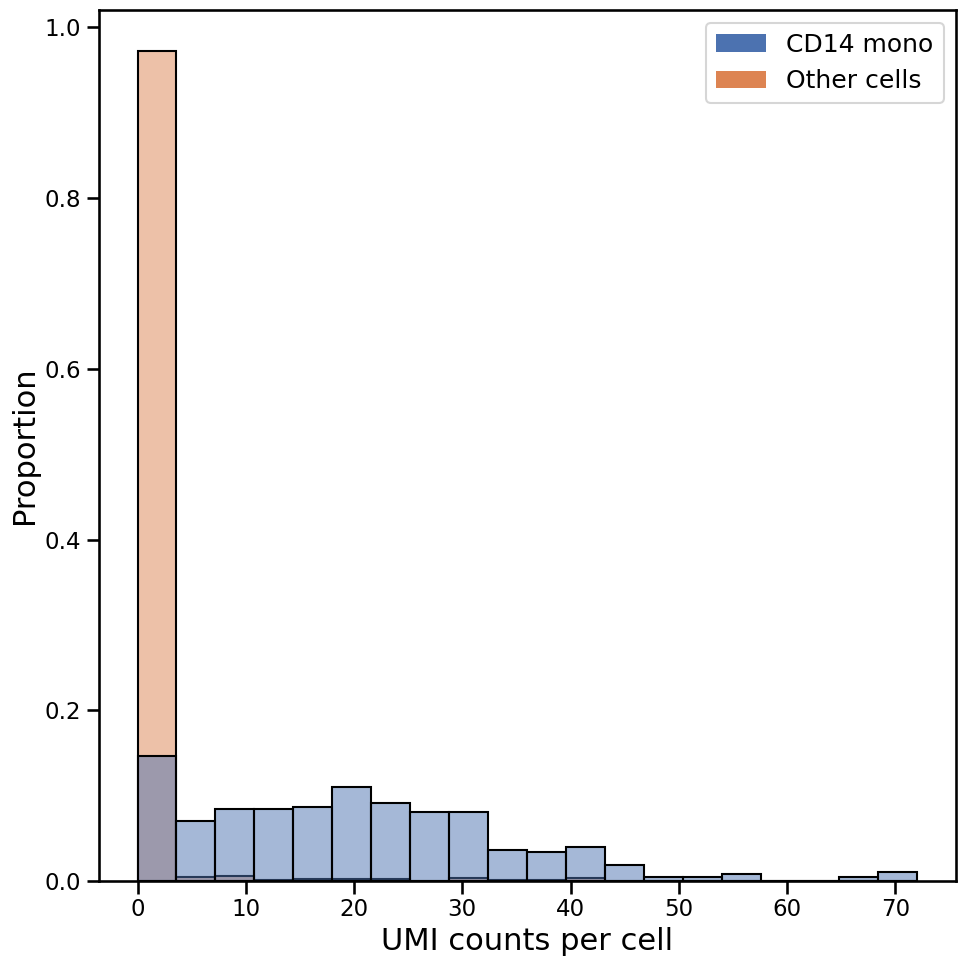

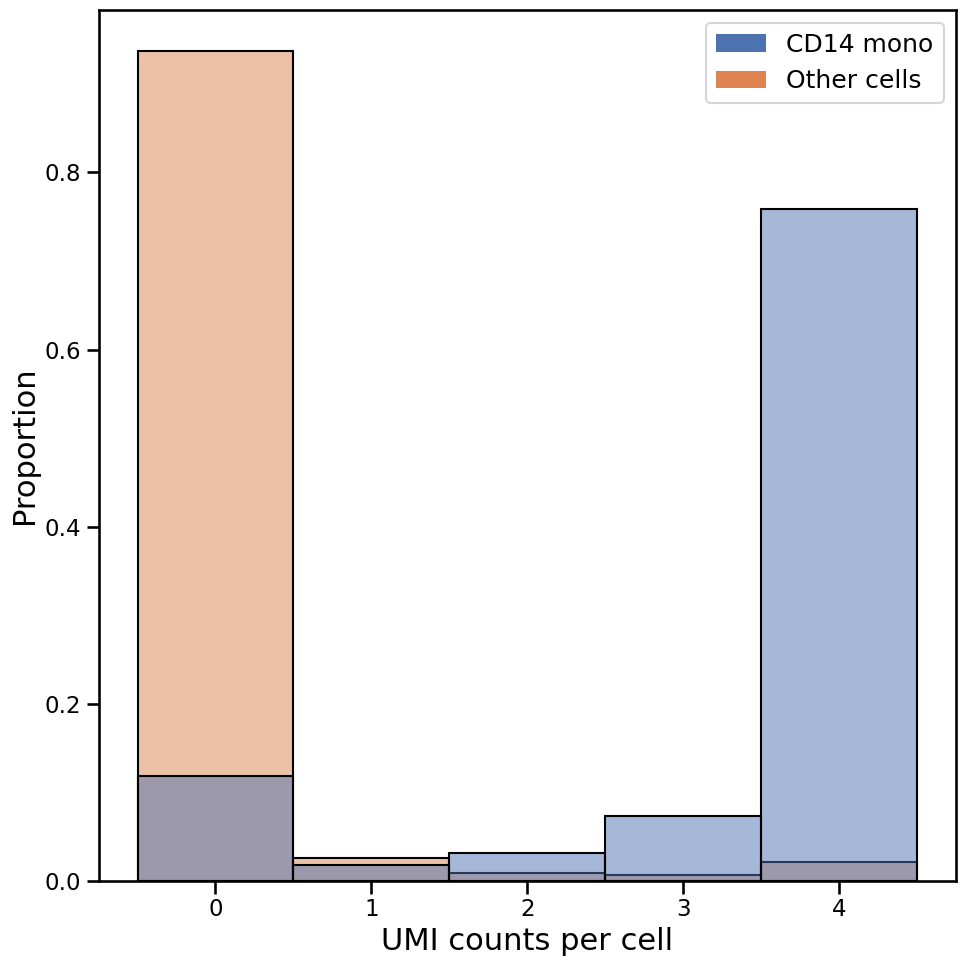

In [5]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Patch

dataset = "1k_PBMCs"  # Change to "10k_PBMCs" if needed

sns.set_context("talk")

j = 1  # naive UMI length

# Load cell annotation labels
labels = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices/annotated_adata_12.h5ad")
reference_labels = labels.obs['majority_voting'].copy()
binary_labels = reference_labels.apply(lambda x: 'CD14_mono' if x == 'CD14_mono' else 'Other cells')

# Load datasets
adata_12   = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_12.h5ad")
adata_naive = sc.read_h5ad(f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/adata_{j}.h5ad")

adata_12.obs['label'] = binary_labels

gene = "FCN1"
g_idx = adata_12.var_names.get_loc(gene)
is_cd14 = (adata_12.obs["label"] == "CD14_mono").values  # boolean array aligned to obs

def dense_col(X, idx):
    col = X[:, idx]
    return col.toarray().ravel() if not isinstance(col, np.ndarray) else col.ravel()

# Use a fixed palette so our manual legend colors match the bars
_palette = sns.color_palette("deep", n_colors=2)
palette_map = {"CD14_mono": _palette[0], "Other cells": _palette[1]}

# -------- Panel A: Ground truth UMI-12 (PMF, shared bins) --------
vals_gt = dense_col(adata_12.X, g_idx)
vals_gt_cd14  = vals_gt[is_cd14]
vals_gt_other = vals_gt[~is_cd14]

# Shared bins computed from combined data
edges_A = np.histogram_bin_edges(np.concatenate([vals_gt_cd14, vals_gt_other]), bins=20)

dfA = pd.DataFrame({
    "counts": np.concatenate([vals_gt_cd14, vals_gt_other]),
    "group":  (["CD14_mono"] * len(vals_gt_cd14)) + (["Other cells"] * len(vals_gt_other))
})

plt.figure(figsize=(10,10))
sns.histplot(
    data=dfA, x="counts", hue="group",
    bins=edges_A, stat="probability", common_norm=False, multiple="layer",
    hue_order=["CD14_mono", "Other cells"], palette=palette_map, legend=False
)
plt.xlabel("UMI counts per cell", fontsize=22)
plt.ylabel("Proportion", fontsize=22)

# Hard-coded legend
ax = plt.gca()
handles = [
    Patch(facecolor=palette_map["CD14_mono"], label="CD14 mono"),
    Patch(facecolor=palette_map["Other cells"], label="Other cells")
]
ax.legend(handles=handles, fontsize=18)

plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/1k_PBMCs/{gene}_gt_UMI_12_pmf.pdf")
plt.show()

# -------- Panel B: Naive UMI-1 (integer bins, integer ticks) --------
vals_nv = dense_col(adata_naive.X, g_idx)
vals_nv_cd14  = vals_nv[is_cd14]
vals_nv_other = vals_nv[~is_cd14]

# Integer-centered bins: [-0.5, 0.5], [0.5, 1.5], etc.
max_val = int(np.max(np.concatenate([vals_nv_cd14, vals_nv_other])))
edges_B = np.arange(-0.5, max_val + 1.5, 1)

dfB = pd.DataFrame({
    "counts": np.concatenate([vals_nv_cd14, vals_nv_other]),
    "group":  (["CD14_mono"] * len(vals_nv_cd14)) + (["Other cells"] * len(vals_nv_other))
})

plt.figure(figsize=(10,10))
sns.histplot(
    data=dfB, x="counts", hue="group",
    bins=edges_B, stat="probability", common_norm=False, multiple="layer",
    hue_order=["CD14_mono", "Other cells"], palette=palette_map, legend=False
)
plt.xlabel("UMI counts per cell", fontsize=22)
plt.ylabel("Proportion", fontsize=22)
plt.xticks(np.arange(0, max_val + 1, 1))

# Hard-coded legend
ax = plt.gca()
handles = [
    Patch(facecolor=palette_map["CD14_mono"], label="CD14 mono"),
    Patch(facecolor=palette_map["Other cells"], label="Other cells")
]
ax.legend(handles=handles, fontsize=18)

plt.tight_layout()
plt.savefig(f"/data/dagyeman/cellranger/bam_file_analysis/figures/1k_PBMCs/{gene}__naive_UMI_{j}_pmf.pdf")

16160.0


### Figure XX: CellTypist Error plot
- make sure the annotations were done without MALAT1

In [ ]:
import os
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
dataset = "1k_PBMCs"  # Change to "10k_PBMCs" if needed
# Paths
regular_path = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/adata_matrices/cell_annotations/annotated_adata_matrices"
inverted_path = f"/data/dagyeman/cellranger/bam_file_analysis/{dataset}/ub_objects/col_aware_nunif_matrices/cell_annotations/annotated_inv_matrices"

# regular_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/adata_matrices/cell_annotations/annotated_adata_matrices"
# inverted_path = "/data/dagyeman/cellranger/bam_file_analysis/10k_PBMCs/ur_objects/inverted2_adata_matrices/cell_annotations/annotated_inv_matrices"

# 1) Load regular annotated adata matrices into a dict
annotated_ads_reg = {
    i: sc.read_h5ad(f"{regular_path}/annotated_adata_{i}.h5ad")
    for i in range(1, 13)
}

# 2) Build consensus ground truth from UMI 8–12
#    a) find common cells across UMI 8–12
cells_8_12 = set(annotated_ads_reg[8].obs_names) 
for i in range(9, 13):
    cells_8_12 &= set(annotated_ads_reg[i].obs_names)
common_cells = sorted(cells_8_12)

#    b) majority‐vote per cell
consensus_labels = {}
for cell in common_cells:
    votes = [annotated_ads_reg[i].obs.loc[cell, 'majority_voting'] for i in range(8, 13)]
    consensus_labels[cell] = Counter(votes).most_common(1)[0][0]

# 3) Prepare ground truth array aligned to common_cells
ground_truth = np.array([consensus_labels[cell] for cell in common_cells], dtype=str)

# 4) Compute error vectors
error_vector_reg = np.zeros(12)
error_vector_inv = np.zeros(12)
print(error_vector_reg)
print(error_vector_inv)

for i in range(1, 13):
    # Regular predictions aligned to consensus cells
    ad_reg = annotated_ads_reg[i]
    present = [c for c in common_cells if c in ad_reg.obs_names]
    preds_reg = ad_reg.obs.loc[present, 'majority_voting'].astype(str).values
    true_aligned = np.array([consensus_labels[c] for c in present], dtype=str)
    error_vector_reg[i - 1] = np.mean(preds_reg != true_aligned)

    # Inverted predictions aligned to consensus cells
    ad_inv = sc.read_h5ad(f"{inverted_path}/annotated_adata_{i}.h5ad")
    present_inv = [c for c in common_cells if c in ad_inv.obs_names]
    preds_inv = ad_inv.obs.loc[present_inv, 'majority_voting'].astype(str).values
    true_aligned_inv = np.array([consensus_labels[c] for c in present_inv], dtype=str)
    error_vector_inv[i - 1] = np.mean(preds_inv != true_aligned_inv)

print(error_vector_reg)
print(error_vector_inv)
print(1 - error_vector_reg[3])

# 5) Plot both error curves
plt.figure(figsize=(10, 10))

# Blue for Naive (Regular)
plt.plot(
    range(1, 13), error_vector_reg, marker='o', linestyle='-',
    label='Naive estimator', markersize=10, linewidth=3, color='#1f77b4'
)

# Green for Collision-aware (Inverted)
plt.plot(
    range(1, 13), error_vector_inv, marker='o', linestyle='-',
    label='Collision-aware estimator', markersize=10, linewidth=3, color='#2ca02c'
)

plt.xlabel('UMI Length', fontsize=20)
plt.ylabel('Proportion of incorrect predictions', fontsize=20)
plt.ylim(bottom=0)
plt.xticks(range(1, 13), fontsize=12)
plt.axhline(y=0, color='k', linestyle='--', linewidth=1)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)
# plt.title('Error in Cell Type Predictions (All Genes, No MALAT1)', fontsize=24)
plt.legend(fontsize=16)
plt.tight_layout()
out_file = f"/data/dagyeman/cellranger/bam_file_analysis/figures/{dataset}/{dataset}_cell_typist_error.pdf"
# os.makedirs(os.path.dirname(out_file), exist_ok=True)
plt.savefig(out_file)
plt.show()

16160.0
0.0


[0.00000000e+00 1.00000004e+00 1.49905496e+04 1.99832025e+04
 2.49737590e+04]


False


379259800 339835544


(11458, 33100)
